# Topic Estimation Steps:


1. Text preprocessing and tokenization

2. Train topic estimation model
    - Make document-term matrix
        - input: tokens 
        - tool: CountVectorizer
    - Make topic distribution matrix
        - input:
            i) document-term matrix -> term-document matrix -> corpus
            ii) dictionary (from gensim, Not pandas dict)
        - tool: Latent Dirichlet Allocation
    - Evaluate coherence
3. Visualization model
    - tool: pyLDAvis
    - also, each piece of text is expressed in terms of a list of topics, and the probability for each topic


# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from gensim import matutils, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models


In [2]:
# in order to use NLTK's lemmatizer, need to download library

import nltk
nltk.download('wordnet')

# to see where it is downloaded to
print(nltk.find('corpora/wordnet.zip'))

/Users/carmen/nltk_data/corpora/wordnet.zip


[nltk_data] Downloading package wordnet to /Users/carmen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Text to be grouped into different topics

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_excel('../data/drug_names_kaggle_TASK.xlsx',
                  header = 1,
                  usecols = [1])

In [5]:
df.head(2)

,Introduction
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding."
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding."


# Topic Estimation

## 1. Text preprocessing and tokenization

In [6]:
def tokenize(text):
    
    list_str_exclude = ['mg', 'ml', 'gm', 'iu']
    # need to add words to this list manually
    
    tokenizer = RegexpTokenizer(r'\w+')
    text = text.lower()
#     print(text)
    tokenized_text = tokenizer.tokenize(text)
#     print(tokenized_text)

    # Remove numbers, but not words that contain numbers.
    tokenized_text = [token for token in tokenized_text if not token.isnumeric()]

    # Remove words that are only one character.
    tokenized_text = [token for token in tokenized_text if len(token) > 1]
    
    # Remove words that are dosage
    tokenized_text = [token for token in tokenized_text if not any(unimportant in token for unimportant in list_str_exclude)]
    
    return tokenized_text

In [7]:
def lemmatize_tokens(tokens):
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [8]:
df['tokens'] = df['Introduction'].apply(lambda x: lemmatize_tokens(tokenize(x)))

In [9]:
df.head(2)

,Introduction,tokens
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]"
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]"


## 2. Train topic estimation model

In [10]:
def create_corpus_dictonary(text_data, max_term_freq, min_term_count):

    def identity_tokenizer(text):
        return text
    
    # create document-term matrix
    count_vectorizer = CountVectorizer(tokenizer = identity_tokenizer,
                                      lowercase = False,
                                      max_df = max_term_freq, # ignoring terms that have a document frequency > x% of the number of document (by percentage)
                                      min_df = min_term_count) # ignoring terms that have a document frequency < x (count) 

    count_matrix = count_vectorizer.fit_transform(text_data)
    print('count_matrix.shape: ', count_matrix.shape)
    
    # create dictionary of index: term
    dictionary = count_vectorizer.get_feature_names_out()
    print('length of dictionary: ', len(dictionary))
    id2word = {v: k for v, k in enumerate(dictionary)}    
    # for coherence evaluation, create dictionary of term: index
    word2id = dict((k, v) for k, v in count_vectorizer.vocabulary_.items())

    d = corpora.Dictionary()
    d.id2token = id2word
    d.token2id = word2id

    
    # create term-document matrix
    count_matrix_T = count_matrix.transpose()
    # convert from sparse to proper format for LDA
    corpus = matutils.Sparse2Corpus(count_matrix_T)
    
    return corpus, d, id2word, word2id


In [11]:
def train_model_get_coherence_score(corpus, id2word, topic_count, word2id):
    
    passes = 10
    iterations = 50 # 50 is the default
    
    lda = models.LdaModel(corpus = corpus,
                          id2word = id2word,
                          num_topics = topic_count,
                          passes = passes,
                          iterations = iterations)
    
    # evaluation coherence
    coherence_model_lda = CoherenceModel(model = lda, 
                                         corpus = corpus, 
                                         dictionary = word2id, 
                                         coherence = 'u_mass'
                                        )
    coherence_lda = coherence_model_lda.get_coherence()
    
    return lda, coherence_lda
    

### fix max_term_freq and min_term_freq, vary topic_count

In [22]:
starttime = time.time()

max_term_freq = 0.8
min_term_count = 1

Corpus, D, Id2word, Word2id = create_corpus_dictonary(df['tokens'], max_term_freq, min_term_count)
print('max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

elapsedtime = time.time() - starttime
print('time taken to calculate: {}'.format(elapsedtime))

count_matrix.shape:  (1000, 2724)
length of dictionary:  2724
max_term_freq = 0.8, min_term_count = 1
time taken to calculate: 0.08510589599609375


/Users/carmen/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
dict_coherence_score_topic_count = {}
for i in range(3, 10):
    Lda, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, i, Word2id)
    dict_coherence_score_topic_count[i] = Coherence_score

In [24]:
dict_coherence_score_topic_count = dict(sorted(dict_coherence_score_topic_count.items()))

Text(0.5, 1.0, 'Max_term_freq = 0.8, min_term_count = 1')

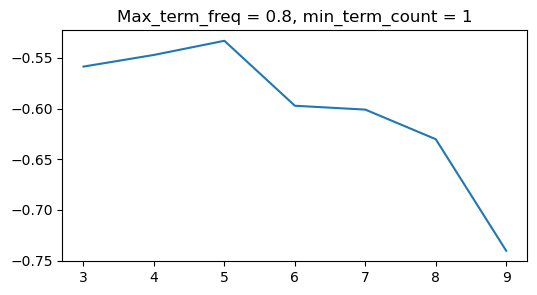

In [25]:
plt.figure(figsize = (6,3))
plt.plot(dict_coherence_score_topic_count.keys(),
        dict_coherence_score_topic_count.values())
plt.title('Max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

# Visualize model

## pyLDAvis

In [26]:
pyLDAvis.enable_notebook()

In [27]:
Lda5, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 5, Word2id)

In [28]:
vis5 = pyLDAvis.gensim_models.prepare(Lda5, Corpus, D, sort_topics = False)
vis5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.114062 -0.038108       1        1  23.381773
1     -0.050842  0.059629       2        1  18.410563
2      0.020195 -0.108632       3        1  13.656050
3     -0.171043 -0.007494       4        1  16.696104
4      0.087629  0.094606       5        1  27.855510, topic_info=          Term         Freq        Total Category  logprob  loglift
419      blood  1595.000000  1595.000000  Default  30.0000  30.0000
420   pressure   731.000000   731.000000  Default  29.0000  29.0000
679      level   799.000000   799.000000  Default  28.0000  28.0000
171  infection   652.000000   652.000000  Default  27.0000  27.0000
418       high   521.000000   521.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
156       know   256.986518  1085.130945   Topic5  -4.9666  -0.1623
124       time   248.712101  1036.834086   Topic5  -4.9994  -0.1495
132       will   231.682327   820.727165   Topic5  -5.0703   0.0133
122         at   242.053348  1051.981370   Topic5  -5.0265  -0.1911
48         get   213.347926   701.085046   Topic5  -5.1527   0.0884

[441 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
98        1  0.705572      about
98        2  0.076972      about
98        3  0.074833      about
98        4  0.014967      about
98        5  0.128286      about
...     ...       ...        ...
207       4  0.003550     worsen
207       5  0.081644     worsen
876       1  0.014942  yellowing
876       3  0.059767  yellowing
876       4  0.926385  yellowing

[1003 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [29]:
Lda4, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 4, Word2id)

In [31]:
print('This model has coherence score = {}'.format(Coherence_score))

This model has coherence score = -0.47604294061306635


In [30]:
vis4 = pyLDAvis.gensim_models.prepare(Lda4, Corpus, D, sort_topics = False)
vis4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.161502  0.011925       1        1  27.284261
1      0.086878  0.078613       2        1  22.078248
2      0.045614 -0.137153       3        1  24.117832
3      0.029010  0.046614       4        1  26.519660, topic_info=          Term         Freq        Total Category  logprob  loglift
420   pressure   739.000000   739.000000  Default  30.0000  30.0000
419      blood  1626.000000  1626.000000  Default  29.0000  29.0000
679      level   821.000000   821.000000  Default  28.0000  28.0000
41         eye   496.000000   496.000000  Default  27.0000  27.0000
171  infection   645.000000   645.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
127       dose   248.363891  1117.510456   Topic4  -4.9516  -0.1767
140       most   224.560880   857.412628   Topic4  -5.0524  -0.0125
39         any   244.922868  1493.622695   Topic4  -4.9656  -0.4807
171  infection   198.608296   645.286198   Topic4  -5.1752   0.1489
59        stop   197.058258   724.600521   Topic4  -5.1830   0.0252

[361 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
98        1  0.032223     about
98        2  0.133189     about
98        3  0.678834     about
98        4  0.156819     about
1027      3  0.967646    aceclo
...     ...       ...       ...
885       2  0.962822  workload
207       1  0.046205    worsen
207       2  0.024880    worsen
207       3  0.639762    worsen
207       4  0.287893    worsen

[755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

# Save model
- best coherence score (and visually best separations) with LDA model with 5 topics

In [32]:
Lda4.save('../models/lda4.model')

In [33]:
pyLDAvis.save_html(vis4, '../models/vis4.html')

## transform corpus into topic distribution matrices 

In [ ]:
corpus_transformed = lda4[corpus]

### function to show original text, tokens, most likely topics and topic terms

In [ ]:
def show_prediction(index):
    
    print(df.iloc[index]['Introduction'])
    
    df = (pd.DataFrame(corpus_transformed[index], columns = ['topic', 'probability'])
                       .sort_values(by = ['probability'], ascending = False)
                       .reset_index(drop = True))
    print()
    
    print(df)
    
    list_topics = []
    for i in range(len(df)):
        if (float(df.iloc[i]['probability']) > 0.1):
            list_topics.append(int(df.iloc[i]['topic']))
    print('most likely topics: ', list_topics)
    print()
    
    for t in list_topics:
        print(lda4.print_topics()[t])
    
    return()
    

In [ ]:
# pd.set_option('display.max_colwidth', 500)
# df['Introduction'][0]
df.iloc[13]['Introduction']

In [ ]:
show_prediction(1)

### transform inf corpus into inf topic distribution matrix

In [ ]:
inf_count_matrix_T = inf_count_matrix.transpose()

inf_corpus = matutils.Sparse2Corpus(inf_count_matrix_T)

In [ ]:
inf_corpus_transformed = lda4[inf_corpus]

### function to show inf text, tokens, most likely topics and topic terms¶

In [ ]:
def show_inf_prediction(index):
    
    print(df_inf.iloc[index])
    
    df = (pd.DataFrame(inf_corpus_transformed[index], columns = ['topic', 'probability'])
                       .sort_values(by = ['probability'], ascending = False)
                       .reset_index(drop = True))
    print()
    
    print(df)
    
    list_topics = []
    for i in range(len(df)):
        if (float(df.iloc[i]['probability']) > 0.1):
            list_topics.append(int(df.iloc[i]['topic']))
    print('most likely topics: ', list_topics)
    print()
    
    for t in list_topics:
        print(lda4.print_topics()[t]) 
    
    return()

## 4. Calculate distance between each piece of text

### tabelog topic probabilities

In [ ]:
df_tabelog_topic_prob = pd.DataFrame(columns = range(4))

for i in range(len(df_tabelog)):
    list_probabilities = corpus_transformed[i]
    dict_probabailites = {item[0]: item[1:] for item in list_probabilities}
    df_probabilities = pd.DataFrame(dict_probabailites)
    df_tabelog_topic_prob = pd.concat([df_tabelog_topic_prob, df_probabilities],
                                     axis = 0)

In [ ]:
df_tabelog_topic_prob.fillna(0, inplace = True)

In [ ]:
df_tabelog_topic_prob.head()

### inf topic probabilities

In [ ]:
df_inf_topic_prob = pd.DataFrame(columns = range(4))

for i in range(len(df_inf)):
    list_probabilities = inf_corpus_transformed[i]
    dict_probabailites = {item[0]: item[1:] for item in list_probabilities}
    df_probabilities = pd.DataFrame(dict_probabailites)
    df_inf_topic_prob = pd.concat([df_inf_topic_prob, df_probabilities],
                                     axis = 0)

In [ ]:
df_inf_topic_prob

### find Jensen-Shannon distance

In [ ]:
# e.g. tabelog entry 0, inf 0
tabelog_inf_distance = distance.jensenshannon(list(df_tabelog_topic_prob.iloc[0]), list(df_inf_topic_prob.iloc[0]))

In [ ]:
tabelog_inf_distance

# Part 2. Clustering
1. Get average text vectors using pre-trained model vectors
2. kMeans clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

## 1. Get text vectors

- to get pretrained word vectors (English)
    - https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html

In [ ]:
import gensim.downloader as api

In [ ]:
gensim_corpus = api.load('text8')

In [ ]:
import inspect
print(inspect.getsource(gensim_corpus.__class__))

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(gensim_corpus)

In [ ]:
print(model.wv.most_similar('tree'))

- Japanese pretrained models, word vectors
    - https://qiita.com/Hironsan/items/8f7d35f0a36e0f99752c
    - https://qiita.com/Hironsan/items/513b9f93752ecee9e670
        - download Word vectors (NEologd)

In [ ]:
local_path = '/Users/carmen/Downloads/'
model = gensim.models.KeyedVectors.load_word2vec_format(local_path + 'model.vec', binary = False)

In [ ]:
# testing
model.most_similar('日本人')

In [ ]:
def get_average_vector_from_tokens(list_tokens):
    list_vectors = []
    
    for i in list_tokens:
        try:
            vector = model[i]
            list_vectors.append(vector)
        except:
            continue
            
    average_vector = np.mean(list_vectors, axis = 0)
    
    return average_vector

In [ ]:
df_tabelog['tabelog_vector'] = df_tabelog['tokens'].apply(lambda x: get_average_vector_from_tokens(x))

## 2. kMeans clustering

In [ ]:
modelkmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 100)

In [ ]:
modelkmeans.fit(list(df_tabelog['tabelog_vector']))

In [ ]:
df_tabelog['kmeans_cluster'] = modelkmeans.predict(list(df_tabelog['tabelog_vector']))

In [ ]:
df_tabelog.head(2)

### visualize using TSNE

In [ ]:
tsne = TSNE(n_components = 2,
           init = 'random',
           random_state = 10,
           perplexity = 10)

In [ ]:
embedding = tsne.fit_transform(list(df_tabelog['tabelog_vector']))

df_embedding = pd.DataFrame(embedding)
df_embedding.rename(columns = {0:'x',
                              1:'y'},
                   inplace = True)

In [ ]:
df_embedding.head()

In [ ]:
df_tabelog = pd.concat([df_tabelog, df_embedding],
                      axis = 1)

In [ ]:
df_tabelog.head(2)

In [ ]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_tabelog['x'],
               df_tabelog['y'],
               hue = df_tabelog['kmeans_cluster'],
               legend = 'full',
               palette = 'Accent')
plt.show()